# Algoritmo Genético para calcular el parámetro de Hubble $H(z)$

Avances hasta ahora: 

1. Empezamos con una poblacion base de funciones y otra de operaciones
2. Se crea la generación 0 combinando estas dos poblaciones bases
3. Se seleccionan individuos de la población 0 a partir del valor de su $\Chi^2$
4. Se elige un porcentaje de la población 0 que contiene menor chi
5. Se conservan los de menor $\Chi^2$ y al resto se les combina(en parejas) y muta aleatoriamente
6. Se crea generación nueva con los mutados/combinados y los con menor $\Chi^2$ de la generación anterior

Errores: 
1. No sé porqué a veces el chi me da un numero imaginario
2. El número de indivudos dentro de una generación se reduce muy rápido
3. El tiempo de ejecución aumenta drásticamente con el número de individuos de la población inicial

In [673]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify, compose, I, pi, log, exp, simplify
from sympy.abc import x
import time



In [674]:
# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        #print(elementos)
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

Simplificador es una función para simplificar las expresiones que dan de trabajar con funciones sympy. Por ejemplo, $x+x$ lo simplifica a $2x$. 

In [675]:
def Simplificador(poblacion):
    x = symbols('x')
    expresiones_simplificadas = [simplify(expresion) for expresion in poblacion]
    return expresiones_simplificadas

Creador genera la población $0$.

In [676]:
# Medir el tiempo de ejecución
inicio_tiempo = time.time()

def Creador(num_poblacion_inicial, poblacion_base, operaciones):
    '''
    Creador recibe: 
    1. El numero de individuos que se desea que tenga la poblacion inicial
    2. Una lista con funciones base cuyas combinaciones crearan la poblacion inicial
    3. una lista con operaciones que actuarán sobre las funciones al momento de combinarlas
    '''
    poblacion_inicial= []
    for n in range(num_poblacion_inicial):
        expresion1 = random.choice(poblacion_base)
        expresion2 = random.choice(poblacion_base)
        operacion = random.choice(operaciones)
        if operacion == 'comp':
            # Se pasan a funciones sympy
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            poblacion_inicial.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            poblacion_inicial.append(expresion)
            
    return poblacion_inicial

# Calcular el tiempo transcurrido
tiempo_transcurrido = time.time() - inicio_tiempo

print(f"Creador tomó {tiempo_transcurrido} segundos en ejecutarse.")

Creador tomó 0.0 segundos en ejecutarse.


Seleccionador selecciona ciertos individuos de la población $0$, favoreciendo a los que tienen menor $\Chi^2$.

In [677]:
# Medir el tiempo de ejecución
inicio_tiempo = time.time()

def Seleccionador(poblacion_inicial, valores_observados, porcentaje_seleccion):
    valores_x = valores_observados
    Chi = np.zeros(len(poblacion_inicial))
    x = symbols('x')
    expresiones_sympy = [sympify(exp) for exp in poblacion_inicial]

    # Lambdify para evaluación eficiente
    funciones_evaluadas = [lambdify(x, expr, 'numpy') for expr in expresiones_sympy]
    valores_x_np = np.array(valores_x)
    z_np = np.array(z)
    desv_np = np.array(desv)

    for n, funcion_evaluada in enumerate(funciones_evaluadas):
        # Evaluar la función con lambdify
        f = funcion_evaluada(valores_x_np)

        # Calcular la diferencia y chi cuadrado
        diferencia = (z_np - f)
        chi = np.sum((diferencia/desv_np)**2)
        chi = 100000000000 if np.isnan(chi) or np.isinf(chi) else chi
        Chi[n] = chi
    #print(Chi)

    # Utilizar funciones de NumPy para cálculos más eficientes
    seleccion = np.percentile(Chi, porcentaje_seleccion)
    #print('Las seleccion realizada por Seleccionador fue: ' + str(seleccion))
    seleccionados = Chi[Chi <= seleccion]
    indices = np.where(Chi <= seleccion)[0]
    funciones_seleccionadas = [poblacion_inicial[i] for i in indices]

    #print('Las funciones seleccionadas por Seleccionador fueron: ' + str(funciones_seleccionadas))

    return funciones_seleccionadas, seleccionados

print(f"Seleccionador tomó {tiempo_transcurrido} segundos en ejecutarse.")

Seleccionador tomó 0.0 segundos en ejecutarse.


En reproductor tengo tres modos. Pero los tres en resumen combinan y mutan a los seleccionados, para crear la nueva generación. 

1. Elegir el mejor 20% de los seleccionados anteriormente y mantenerlos. El otro 80% se combina y un 10% de estos último se muta. 
2. Dejar un elemento de la población original y combinar/mutar todos los demás. 
3. Combinar a todos los seleccionados y mutar a un 10% de ellos. En la nueva generación están los padres e hijos (es el modo que está ahora).

In [678]:
# Medir el tiempo de ejecución
inicio_tiempo = time.time()

def Reproductor(funciones_seleccionadas, operaciones, porcentaje_combinacion, Chi_seleccionados, porcentaje_mutacion, poblacion_base): 

    #print('funciones_sleccionadas: ' + str(funciones_seleccionadas))

    #elegir el 20% con menor chi de los seleccionados
    #mejor_seleccion = np.percentile(Chi_seleccionados, int(100 - porcentaje_combinacion)) 
    #mejores_chi = Chi_seleccionados[Chi_seleccionados <= mejor_seleccion]
    #mejores_indices = np.where(Chi_seleccionados <= mejor_seleccion)[0]
    #mejores_funciones = [funciones_seleccionadas[i] for i in mejores_indices]

    #print('mejores_funciones: ' + str(mejores_funciones))
    #print(len(mejores_funciones))
        
    combinados = []
    #funciones_a_combinar = np.delete(funciones_seleccionadas, 0)
    funciones_a_combinar = funciones_seleccionadas

    for n in range(1, len(funciones_a_combinar)):

        # Se eligen padres tal que sean funciones diferentes siempre
        expresion1 = funciones_a_combinar[n]
        indice = random.randint(0, len(funciones_a_combinar)-1)
        while indice == n:
            indice = random.randint(0, len(funciones_a_combinar)-1)
        expresion2 = funciones_a_combinar[indice]

        # Se elige operacion que los combinará
        operacion = random.choice(operaciones)
        if operacion == 'comp':
            # Se pasan a funciones sympy
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            composicion = f1.subs(x, f2)
            combinados.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            combinados.append(expresion)

    #print('funciones_combinadas: ' + str(combinados))
    #print(len(combinados))

    # Se transforma combinados a numpy array
    combinados = np.array(combinados)

    # Empieza mutacion
    num_mutacion = int(len(combinados)*(porcentaje_mutacion/100))

    mutaciones = []
    funciones_a_mutar = []

    # Se eligen (dentro de combinados) funciones a mutar tal que no sean iguales entre si
    for n in range(0, num_mutacion): 
        if n == 0:
            expresion_m = random.choice(combinados)
            funciones_a_mutar.append(expresion_m)
        else:
            expresion_m = random.choice(combinados)
            while expresion_m in funciones_a_mutar:
                expresion_m = random.choice(combinados)
            funciones_a_mutar.append(expresion_m)

        # Se elige una funcion base y una operacion base para mutar ###QUIZA ESTO SE TENGA QUE OPTIMIZAR###
        expresion2 = random.choice(poblacion_base)
        operacion = random.choice(operaciones)

        #print('funciones_a_mutar: ' +str(funciones_a_mutar))

        if operacion == 'comp':
            x = symbols('x')
            expresiones = [expresion_m, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            mutaciones.append(str(composicion))
        else: 
            expresion = f"{expresion_m} {operacion} {expresion2}"
            mutaciones.append(expresion)
    
    #print('funciones_mutadas: ' + str(mutaciones))
    #print(len(mutaciones))
            
    # Agrega los combinados que no fueron mutados y las mejores funciones seleccionadas al inicio
            
    indices_no_mutados = np.array([i for i, elem in enumerate(combinados) if elem not in funciones_a_mutar])
    funciones_sin_mutar = combinados[indices_no_mutados]
    funciones_sin_mutar = funciones_sin_mutar.tolist()
    
    mutaciones += funciones_sin_mutar + funciones_seleccionadas

    nueva_generacion = Simplificador(mutaciones)
    #print('largo_nueva_generacion: ' + str(len(nueva_generacion)))

    return nueva_generacion

# Calcular el tiempo transcurrido
tiempo_transcurrido = time.time() - inicio_tiempo

print(f"Reproductor tomó {tiempo_transcurrido} segundos en ejecutarse.")

Reproductor tomó 0.0 segundos en ejecutarse.


Este el el código general del algoritmo genético. Se implementan las $3$ funciones definidas anteriormente.

In [679]:
def GA_2(num_generaciones, num_poblacion_inicial, poblacion_base, operaciones, valores_observados, porcentaje_seleccion, porcentaje_combinacion, porcentaje_mutacion):

    '''
    Hay tres formas que se finalice el código:
    1. Que se cumpla con el número de generaciones ingresado como argumento
    2. Que se llegue a una población de tamaño = 1
    3. Que se llegue a una población con todos los individuos iguales
    '''
    Poblacion = []
    Seleccion_funciones = []
    Seleccion_Chi = []
    Generacion = []
    
    for n in range(0, num_generaciones):
        print('Número de Generación:' +str(n))
        if n == 0:

            inicio_tiempo = time.time()
            P = Creador(num_poblacion_inicial, poblacion_base, operaciones)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Creador tomó {tiempo_transcurrido} segundos en ejecutarse.")

            Poblacion.append(P)

            inicio_tiempo = time.time()
            S = Seleccionador(Poblacion[n], valores_observados, porcentaje_seleccion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Seleccionador tomó {tiempo_transcurrido} segundos en ejecutarse.")

            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            inicio_tiempo = time.time()
            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion, poblacion_base)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Reproductor tomó {tiempo_transcurrido} segundos en ejecutarse.")

            Generacion.append(R)

            print('Generación inicial:' + str(Generacion[n]))

        else: 

            inicio_tiempo = time.time()
            S = Seleccionador(Generacion[n-1], valores_observados, porcentaje_seleccion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Seleccionador tomó {tiempo_transcurrido} segundos en ejecutarse.")

            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            if len(Seleccion_funciones[n]) == 1:
                print("Deteniendo el código porque la generación solo tiene 1 individuo")
                Generacion.append(Seleccion_funciones[n])
                break

            # Evaluar si todos los elementos de Seleccion_funciones son iguales al final de la iteración
            if all(elemento == Seleccion_funciones[n][0] for elemento in Seleccion_funciones[n]):
                print("Deteniendo el código porque todos los individuos de la generación son iguales al final de la iteración")
                Generacion.append(Seleccion_funciones[n])
                break
            
            inicio_tiempo = time.time()
            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion, poblacion_base)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Reproductor tomó {tiempo_transcurrido} segundos en ejecutarse.")
            
            Generacion.append(R)

            print('Nueva Generación:' + str(Generacion[-1]))
    
    if n == num_generaciones-1:
        Generacion[-1] = Simplificador(Generacion[-1])
        print('Última Generación (se llegó a la generación pedida): ' + str(Generacion[-1]))

    else:
        Generacion[-1] = Simplificador(Generacion[-1])
        print('Última Generación: ' + str(Generacion[-1]))

    return Generacion[-1]

## Pruebas del código

Tras varios intentos siempre la best fit function termina siendo la identidad. Al graficarla, tengo que multiplicarla por $70$ para que se acerque a los valores de los datos. 

In [680]:
import warnings

# Desactivar la advertencia de desbordamiento en potencias
warnings.filterwarnings("ignore", category=RuntimeWarning)

poblacion_base_borrador = ['x', 'exp(x)', 'log(x)', 'x**2']

poblacion_base = ['(1+x)', '(1+x)**2', '(1+x)**3']

operaciones = ['*', '+', '-', 'comp'] 

tercer_intento = GA_2(5, 100, poblacion_base_borrador, operaciones, z, 20, 80, 10)

Número de Generación:0
Creador tomó 0.019946575164794922 segundos en ejecutarse.
Seleccionador tomó 0.09278392791748047 segundos en ejecutarse.
Reproductor tomó 0.25328993797302246 segundos en ejecutarse.
Generación inicial:[-x*log(x) + x + log(x), 2*x**2 - exp(x), x**3*log(x), -x**2*exp(x) + x**2 - exp(x), x**2*log(x)**2, x*log(x)*log(x*log(x)), x*log(x) - 2*exp(x), 2*x*log(x), x**3*log(x), log(exp(x**2)), 0, x**3*log(x), x*(-x + log(x)), x**4, (1 - x**2)*log(x), x**2*log(x)**2, log(exp(x)), x*(x - log(x)), 0, x*(1 - x), 0, x*(x + log(x)), -exp(x)*log(x) + exp(x) - log(x), x**2, x**2, 2*x, 0, x*log(x), x, x*log(x), x*log(x), x*log(x), x*log(x), log(exp(x)), 0, x**2, x*log(x), x**2, 0, x*log(x), log(exp(x)), x**2, x**2, x, x, 0, x**2, 0]
Número de Generación:1
Seleccionador tomó 0.021941423416137695 segundos en ejecutarse.
Reproductor tomó 0.23540496826171875 segundos en ejecutarse.
Nueva Generación:[log(exp(x))**2, log(exp(x**4*log(x)**4)), x**2*log(x)**2, -x**2 + log(exp(x)), x*(x - 

In [681]:
# Elegir mejor

print(tercer_intento)

# Convertir de expresiones sympy a funciones de Python
funcion = lambdify(x, tercer_intento[0], 'numpy')

evaluada = funcion(z)

[x, x, x]


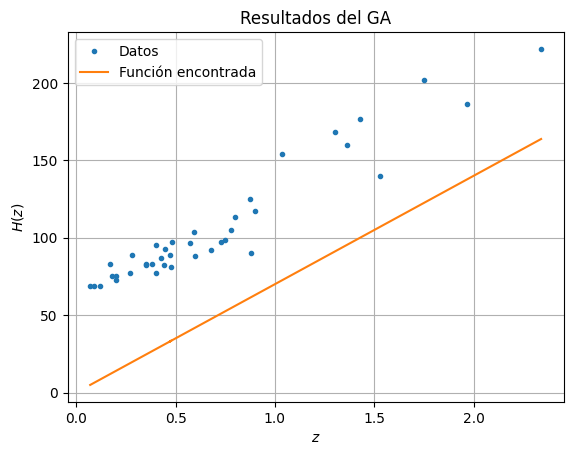

In [682]:
# Graficar Resultados

plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada*70, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.grid(True)
plt.show()